# Contrastive Explanation Method
[Alibi MNIST Reference Code](https://github.com/SeldonIO/alibi/blob/524d786c81735ed90da2d2c68851c1145fa1b595/examples/cem_mnist.ipynb)

Copyright 2020, Denis Rothman, MIT License. Added training options form and auto-encoder options form. Added Alibi installation.


In [ ]:
#@title Install Alibi
try:
  import alibi
except:
  !pip install alibi

     |████████████████████████████████| 225kB 7.7MB/s 
     |████████████████████████████████| 110.5MB 49kB/s 
     |████████████████████████████████| 51kB 3.5MB/s 
     |████████████████████████████████| 276kB 48.3MB/s 
     |████████████████████████████████| 28.0MB 119kB/s 
     |████████████████████████████████| 512kB 51.5MB/s 
     |████████████████████████████████| 3.8MB 37.8MB/s 
     |████████████████████████████████| 921kB 50.7MB/s 
     |████████████████████████████████| 204kB 52.1MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394120 sha256=78b030a51eb343243e57809b1e73a8f77c613d67ec827b8dcf50a708034a8e88
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=7ab65b0647a658d24ba1ebf5ed6bbf219e05e68d37e6243ef8713ce35ba194b7
  Stored in directory: /root/.cache/pip/wheels/2a/2b

In [ ]:
#@title Import modules
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # suppress deprecation messages
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CEM

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


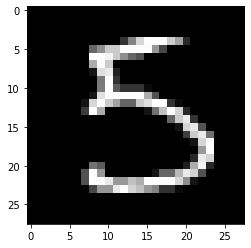

In [ ]:
#@title Load and prepare MNIST Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[15]);

In [ ]:
#@title Preparing data: scaling the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_test[1])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.45490196 0.49019608
  0.6705882

In [ ]:
#@title Preparing data: shaping the data
print("Initial Shape",x_test.shape)
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)

Initial Shape (10000, 28, 28)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)


In [ ]:
#@title Preparing data: categorizing the data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

y_train shape: (60000, 10) y_test shape: (10000, 10)


In [ ]:
#@title Create and train CNN model
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn


In [ ]:
train_cnn = 'yes' #@param ["yes","no"]
if train_cnn=="yes":
  cnn = cnn_model()
  cnn.summary()
  cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
  cnn.save('mnist_cnn.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0     

In [ ]:
#@title Load and test accuracy on test dataset
cnn = load_model('/content/mnist_cnn.h5')
cnn.summary()
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0     

In [ ]:
#@title Define and train autoencoder
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    autoencoder = Model(x_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [ ]:
train_auto_encoder = 'yes' #@param ["yes","no"]

if train_auto_encoder=="yes":
  ae = ae_model()
  ae.summary()
  ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
  ae.save('mnist_ae.h5', save_format='h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 1)         145       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 16)        0   

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 1)         145       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 16)        0   

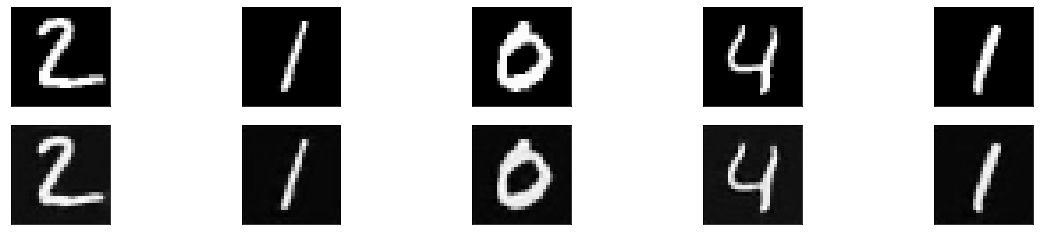

In [ ]:
#@title Compare original with decoded images
ae = load_model('/content/mnist_ae.h5')
ae.summary()
decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
#@title Generate contrastive explanation with pertinent negative
#Explained instance
idx = 15
X = x_test[idx].reshape((1,) + x_test[idx].shape)

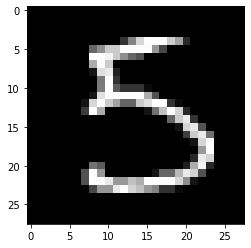

In [ ]:
plt.imshow(X.reshape(28, 28));

In [ ]:
#@title Model prediction
cnn.predict(X).argmax(), cnn.predict(X).max()

(5, 0.9999294)

In [ ]:
#@title CEM parameters
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes 
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or 
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_train.min(),x_train.max())  # feature range for the perturbed instance
clip = (-1000.,1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative, 
                  # so positive/negative perturbations imply adding/removing features

In [ ]:
#@title initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range, 
          gamma=gamma, ae_model=ae, max_iterations=max_iterations, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent negative prediction: 8


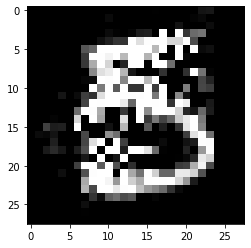

In [ ]:
#@title Pertinent negative
print('Pertinent negative prediction: {}'.format(explanation.PN_pred))
plt.imshow(explanation.PN.reshape(28, 28));

In [ ]:
#@title Generate pertinent positive
mode = 'PP'

In [ ]:
#@title initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range, 
          gamma=gamma, ae_model=ae, max_iterations=max_iterations, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent positive prediction: 5


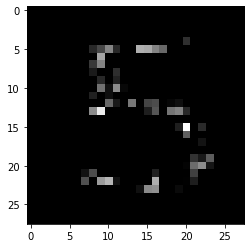

In [ ]:
#@title Pertinent positive
print('Pertinent positive prediction: {}'.format(explanation.PP_pred))
plt.imshow(explanation.PP.reshape(28, 28));